In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import gc
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)
pd.set_option('max_colwidth', 200)

warnings.filterwarnings('ignore')
tqdm.pandas()

%matplotlib inline

### 用户表

In [2]:
train_user = pd.read_csv('../input/train/train_user.csv')
test_user = pd.read_csv('../input/test/test_user.csv')

In [3]:
train_user.head()

phone_no_m  \
0  672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1   
1  5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674   
2  eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7   
3  0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c   
4  28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20   

  city_name county_name  idcard_cnt  arpu_201908  arpu_201909  arpu_201910  \
0        绵阳       江油分公司           1        46.06        45.00         45.0   
1        德阳       旌阳分公司           1        79.00        79.20         79.1   
2        成都       金堂分公司           2        18.85        24.45         22.0   
3        成都       高新分公司           2        19.20        29.65        130.4   
4        德阳       旌阳分公司           1        50.00        50.00         50.0   

   arpu_201911  arpu_201912  arpu_202001  arpu_202002  arpu_202003  label  
0        45.00        45.00         45.0         45.0         45.0      0  
1        79.30        41.40         34.1         59.4         60.0      0  
2        21.40        22.15         21.1         61.3         63.0      0  
3       173.12        19.00         19.0         19.0         23.2      0  
4        50.00        50.00         50.0         50.0         50.0      0

In [4]:
test_user.head()

phone_no_m  \
0  22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf94e017b4ffd67e26520af18637ad91bde69abd831cc36cdc0c5af5e57bc280f95f79efef7bfa9c6926   
1  5220d4b8429bdba3971a7b46a088c6b8fa6710f40607598ac1219daab6071510b3f66f78637420574dbb2d5488d44de9d4360a644bbe4ec45aaa4b7513bdc886   
2  7d19dd2b50ced56f03d23bf928cf34dc570a48525571a868ffdcdc53a865b7a41c386a6f1d6567dd4a710530b933308c77d1ef89f77b580d1983dadd3de162ea   
3  134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4fd3a9f9d9bf4a033e791b7199db980b0678020bdf689d719306a5c694ffa47b4ba2bec43ceda68dfc1   
4  2356dcd6759d50455ddaeed03c838843558e9182d5962f8a4c81a9a178063c49ab988750f795bb6c5462aee5dace2ad9fd18dbb1a6619dbb1e771e9b0f192da9   

  city_name county_name  idcard_cnt  arpu_202004  
0        成都       金牛分公司           1          9.0  
1      天府新区      天府直属部门           1          NaN  
2        成都       锦江分公司           1          9.0  
3        绵阳       江油分公司           1        138.7  
4        成都       青羊分公司           2         39.0

1. 查看训练集和测试集电话号码的交集

In [5]:
tr_u = set(list(train_user['phone_no_m'].unique()))
te_u = set(list(test_user['phone_no_m'].unique()))

tr_u & te_u

set()

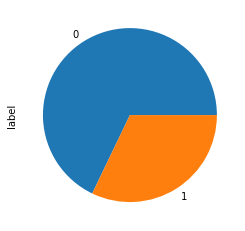

In [6]:
_ = train_user.label.value_counts().plot.pie()

In [7]:
train_user.shape, test_user.shape

((6106, 13), (2045, 5))

In [8]:
# 训练集只取最后一个月的数据
train_user['arpu_202004'] = train_user['arpu_202003']

train_user.drop(['arpu_201908', 'arpu_201909', 'arpu_201910', 'arpu_201911',
                 'arpu_201912', 'arpu_202001', 'arpu_202002', 'arpu_202003'],
                axis=1,
                inplace=True)
train_user.head()

phone_no_m  \
0  672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1   
1  5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674   
2  eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7   
3  0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c   
4  28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20   

  city_name county_name  idcard_cnt  label  arpu_202004  
0        绵阳       江油分公司           1      0         45.0  
1        德阳       旌阳分公司           1      0         60.0  
2        成都       金堂分公司           2      0         63.0  
3        成都       高新分公司           2      0         23.2  
4        德阳       旌阳分公司           1      0         50.0

#### LabelEncoder

In [9]:
lbl = LabelEncoder()

df_user = pd.concat([train_user, test_user], axis=0, ignore_index=True)

for f in tqdm(['city_name', 'county_name']):
    df_user[f] = df_user[f].fillna('NA')
    df_user[f] = lbl.fit_transform(df_user[f].astype(str))
    
df_user.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 200.16it/s]


arpu_202004  city_name  county_name  idcard_cnt  label  \
0         45.0         16           97           1    0.0   
1         60.0         10           82           1    0.0   
2         63.0         11          160           2    0.0   
3         23.2         11          181           2    0.0   
4         50.0         10           82           1    0.0   

                                                                                                                         phone_no_m  
0  672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1  
1  5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674  
2  eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7  
3  0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c  
4  28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20

### 通话表

In [10]:
train_voc = pd.read_csv('../input/train/train_voc.csv')
test_voc = pd.read_csv('../input/test/test_voc.csv')

train_voc['start_datetime'] = train_voc['start_datetime'].astype('datetime64')
test_voc['start_datetime'] = test_voc['start_datetime'].astype('datetime64')

In [11]:
train_voc.head()

phone_no_m  \
0  3b6bef554a4754fa9977b50d99e6777c9fb26e585961a453bab3a2eba9f25eb510376bb89a345fb1a073e3a99da296d0f3c40aec8d0b4efd159eae4acb46f3c8   
1  3b6bef554a4754fa9977b50d99e6777c9fb26e585961a453bab3a2eba9f25eb510376bb89a345fb1a073e3a99da296d0f3c40aec8d0b4efd159eae4acb46f3c8   
2  ecd1b3f5a38576ef9872d1cb7a762f31869153de736e7aa43742ebd2ce6ffac1e6be304c79819a8f3770c1546b11f779be225ff0d0a18eb02f29ca4ef2c964ce   
3  41a97bdfe77f3210deba78689baecb110922878be2f14c2b17416d04da12fe75fe3ecd80de2be43f5f2615557640e588d08b81d504d73f25aa7a40726d3acf4d   
4  41a97bdfe77f3210deba78689baecb110922878be2f14c2b17416d04da12fe75fe3ecd80de2be43f5f2615557640e588d08b81d504d73f25aa7a40726d3acf4d   

                                                                                                                      opposite_no_m  \
0  3572f19c52faeea5111ddd79dfc3643171d00e6d8b3fd9d6d04701a1873702a50004019f70d8a4c766d24e7768d356f6420ca28e27a7b0343f0acf3116655a58   
1  3572f19c52faeea5111ddd79dfc3643171d00e6d8b3fd9d6d04701a1873702a50004019f70d8a4c766d24e7768d356f6420ca28e27a7b0343f0acf3116655a58   
2  c386d11d5203136e924e070afcac734cdaea6691472e841fe981d839abdb7c9ad794024c7c484b86d5cf5553a1531079a1a3e3ec1e932cea62293d0d04eb13b7   
3  79ef199a532bcb9a89990d0996cee3d40557f06b9e5265fee8357eaca7735ec4ed65670d446c09482c535bd4eb1e3e07c5bd49704e49b50958b2e54c34f29a7b   
4  e273542129cf7fa37c28d3f4c95b7b9e8bcb561bbabc50063a1a5a1fd133a14f62f8a59649e5dffacccdb661300a7ef5aaea710b8a1155c4904647d9d5877e49   

   calltype_id      start_datetime  call_dur city_name county_name  \
0            2 2019-10-17 17:16:25        13       NaN         NaN   
1            2 2019-10-17 17:36:20        16       NaN         NaN   
2            1 2019-08-28 09:46:50        18       NaN         NaN   
3            1 2019-09-18 16:19:20        34       NaN         NaN   
4            2 2019-09-18 16:18:46        23       NaN         NaN   

                                                                                                                             imei_m  
0  d2940d7cde5092d809af2e4bb8f6936a405382bd541542c5ccbb9d577d7d340ea032cca1174d33cca05393fbfd45fc0715198781d726679a09db74dac778c9c5  
1  d2940d7cde5092d809af2e4bb8f6936a405382bd541542c5ccbb9d577d7d340ea032cca1174d33cca05393fbfd45fc0715198781d726679a09db74dac778c9c5  
2  071e8dcb4010c643c48339cb8abf4a69e03b37afade98ded48ae19b2dafe965f5b28299131441a068b066588492389a3e66c3105f3cd5ab8c3eefff0015373f5  
3  5f054945a5037e688abe0ef36d88a0fd351d476e3320c22cb3da7692d4ba4ba3e7752253ef74c6af1763089b830687d06535dfc6ba4f411196889364868425af  
4  5f054945a5037e688abe0ef36d88a0fd351d476e3320c22cb3da7692d4ba4ba3e7752253ef74c6af1763089b830687d06535dfc6ba4f411196889364868425af

In [12]:
# 只取最后一个月的数据
train_voc = train_voc[train_voc['start_datetime'] >= '2020-03-01 00:00:00']
train_voc = train_voc.reset_index(drop=True)

df_voc = pd.concat([train_voc, test_voc],
                   axis=0,
                   ignore_index=True)

In [13]:
# 时间切割

df_voc['voc_day'] = df_voc['start_datetime'].dt.day
df_voc['voc_hour'] = df_voc['start_datetime'].dt.hour
df_voc['voc_ts'] = pd.to_timedelta(df_voc['start_datetime'], unit='ns').dt.total_seconds().astype(int)

df_voc = df_voc.sort_values(by='voc_ts').reset_index(drop=True)

In [14]:
# 一天内通话统计量

df_voc['voc_day_count'] = df_voc.groupby(['phone_no_m', 'voc_day'])['phone_no_m'].transform('count')
df_voc['voc_day_count_max'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('max')
df_voc['voc_day_count_min'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('min')
df_voc['voc_day_count_mean'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('mean')
df_voc['voc_day_count_std'] = df_voc.groupby('phone_no_m')['voc_day_count'].transform('std')

del df_voc['voc_day_count']

In [15]:
# 一小时内通话统计量

df_voc['voc_hour_count'] = df_voc.groupby(['phone_no_m', 'voc_hour'])['phone_no_m'].transform('count')
df_voc['voc_hour_count_max'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('max')
df_voc['voc_hour_count_min'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('min')
df_voc['voc_hour_count_mean'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('mean')
df_voc['voc_hour_count_std'] = df_voc.groupby('phone_no_m')['voc_hour_count'].transform('std')

del df_voc['voc_hour_count']

In [16]:
# 总量

df_voc['voc_count'] = df_voc.groupby('phone_no_m')['phone_no_m'].transform('count')

In [17]:
df_voc.head()

phone_no_m  \
0  1143237c02511244c4c9d8b1ca77c19f79b805a8577f3e62a84c8bc4359c930497a2363986cc3421912ee4589fb079ccbc3be3c330a6dd22b594a3433c9b414a   
1  23e7b33b67d844031bcb1b6d4d4323786d0ff72276d682bd39b71217fed16278a7e8895feb0f96552553cef0018df935b9171b2e68cc92761b420dcdb6575c82   
2  333623561fc36866d7afcd9574c1572ecd7c9c68b9e372cd9c784baf0d9f4a3978c0ca98f57f912b0289f245046e305ac81755126d9df92883e7103859eb851c   
3  333623561fc36866d7afcd9574c1572ecd7c9c68b9e372cd9c784baf0d9f4a3978c0ca98f57f912b0289f245046e305ac81755126d9df92883e7103859eb851c   
4  23e7b33b67d844031bcb1b6d4d4323786d0ff72276d682bd39b71217fed16278a7e8895feb0f96552553cef0018df935b9171b2e68cc92761b420dcdb6575c82   

                                                                                                                      opposite_no_m  \
0  d7196a9499c13ce27d4c70ccc1576ebef915caf602a1ce2cb0b7defd20c7a246423cb2c3508418e930fa31242787bcc1428c4e18f2fd81b796fe629615825ec3   
1  f40eb0b09ad309078f33940d5b5cddbf87bd3dd9433f6d780b88777b0c98babfe410cdd771af79cb0a0335fca1f5d1211fa1743654fb08675b3c675b269a642a   
2  a41fbfe0210cfa0305d678111a03a2049fc5e91073cc8a46d2ac46eb5a535b8cca8d19d2bc50435adcdc3f6de4de84ec15a216c9a1cc6d2e84f099fe05a20bce   
3  a41fbfe0210cfa0305d678111a03a2049fc5e91073cc8a46d2ac46eb5a535b8cca8d19d2bc50435adcdc3f6de4de84ec15a216c9a1cc6d2e84f099fe05a20bce   
4  f40eb0b09ad309078f33940d5b5cddbf87bd3dd9433f6d780b88777b0c98babfe410cdd771af79cb0a0335fca1f5d1211fa1743654fb08675b3c675b269a642a   

   calltype_id      start_datetime  call_dur city_name county_name  \
0            1 2020-03-01 00:00:03        69        雅安         天全县   
1            1 2020-03-01 00:01:02        21       NaN         NaN   
2            1 2020-03-01 00:02:25       103        成都         武侯区   
3            1 2020-03-01 00:02:25       103        成都         武侯区   
4            1 2020-03-01 00:03:15         1       NaN         NaN   

                                                                                                                             imei_m  \
0  2a00a56a28c548e519e2e406bfdf7e2d6871207167a74378cbb43682aedbeb36e77c1db898be68683b4c9a028f87cb49ad8f827f248944c2a1ee839674d7aaae   
1  2437a08877d9e9dfe2decdc144952e20cbda3ff17902ba0a85cced4d76c75c16d40d5804f99364bea9e7f00654721c8bbb2a8bccbb951f6f2c996a5396b5289b   
2  127fd4d72ea49c9428766adb8e68f0dbb822668b319f20f1b39a1f914746d73d9b0acfb4cec0fee16fd42661090eb991ad7ba41200acbd7af216f12174fbb74d   
3  127fd4d72ea49c9428766adb8e68f0dbb822668b319f20f1b39a1f914746d73d9b0acfb4cec0fee16fd42661090eb991ad7ba41200acbd7af216f12174fbb74d   
4  2437a08877d9e9dfe2decdc144952e20cbda3ff17902ba0a85cced4d76c75c16d40d5804f99364bea9e7f00654721c8bbb2a8bccbb951f6f2c996a5396b5289b   

   voc_day  voc_hour      voc_ts  voc_day_count_max  voc_day_count_min  \
0        1         0  1583020803                 32                  1   
1        1         0  1583020862                 44                  1   
2        1         0  1583020945                 72                  1   
3        1         0  1583020945                 72                  1   
4        1         0  1583020995                 44                  1   

   voc_day_count_mean  voc_day_count_std  voc_hour_count_max  \
0           13.351562           8.482129                  33   
1           18.729730          11.004060                  46   
2           33.888889          23.026947                  38   
3           33.888889          23.026947                  38   
4           18.729730          11.004060                  46   

   voc_hour_count_min  voc_hour_count_mean  voc_hour_count_std  voc_count  
0                   1            20.914062            8.505156        256  
1                   1            28.803440           12.130883        407  
2                   1            27.940171            8.852869        468  
3                   1            27.940171            8.852869        468  
4                   1            28.803440           12.1

### 短信表

In [18]:
train_sms = pd.read_csv('../input/train/train_sms.csv')
test_sms = pd.read_csv('../input/test/test_sms.csv')

train_sms['request_datetime'] = train_sms['request_datetime'].astype('datetime64')
test_sms['request_datetime'] = test_sms['request_datetime'].astype('datetime64')

In [19]:
# 同样只取最后一个月的数据

train_sms = train_sms[train_sms['request_datetime'] >= '2020-03-01 00:00:00']
train_sms = train_sms.reset_index(drop=True)

df_sms = pd.concat([train_sms, test_sms])

In [20]:
# 时间切割

df_sms['sms_day'] = df_sms['request_datetime'].dt.day
df_sms['sms_hour'] = df_sms['request_datetime'].dt.hour
df_sms['sms_ts'] = pd.to_timedelta(df_sms['request_datetime'], unit='ns').dt.total_seconds().astype(int)

df_sms = df_sms.sort_values(by='sms_ts').reset_index(drop=True)

In [21]:
# 一天内短信统计量

df_sms['sms_day_count'] = df_sms.groupby(['phone_no_m', 'sms_day'])['phone_no_m'].transform('count')
df_sms['sms_day_count_max'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('max')
df_sms['sms_day_count_min'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('min')
df_sms['sms_day_count_mean'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('mean')
df_sms['sms_day_count_std'] = df_sms.groupby('phone_no_m')['sms_day_count'].transform('std')

del df_sms['sms_day_count']

In [22]:
# 一小时内短信统计量

df_sms['sms_hour_count'] = df_sms.groupby(['phone_no_m', 'sms_hour'])['phone_no_m'].transform('count')
df_sms['sms_hour_count_max'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('max')
df_sms['sms_hour_count_min'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('min')
df_sms['sms_hour_count_mean'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('mean')
df_sms['sms_hour_count_std'] = df_sms.groupby('phone_no_m')['sms_hour_count'].transform('std')

del df_sms['sms_hour_count']

In [23]:
# 总量

df_sms['sms_count'] = df_sms.groupby('phone_no_m')['phone_no_m'].transform('count')

In [24]:
df_sms.head()

phone_no_m  \
0  05b14594c2dfe7cecbf8b8e87220e92b8e7d7cfd81a9483262eea5d3347a314a154ab2902a7becb8b7657ef6171a9a6c095f2529e17eaced79c1b3f87ffb9dff   
1  05b14594c2dfe7cecbf8b8e87220e92b8e7d7cfd81a9483262eea5d3347a314a154ab2902a7becb8b7657ef6171a9a6c095f2529e17eaced79c1b3f87ffb9dff   
2  279b5823890d1af8035dadb33f6e8471fdc2832e907d1aa00c5f5bf47a7fbf451868c557233c679aa3fad7ba068010c059491a3c9029136a3e14e800cf47239c   
3  279b5823890d1af8035dadb33f6e8471fdc2832e907d1aa00c5f5bf47a7fbf451868c557233c679aa3fad7ba068010c059491a3c9029136a3e14e800cf47239c   
4  279b5823890d1af8035dadb33f6e8471fdc2832e907d1aa00c5f5bf47a7fbf451868c557233c679aa3fad7ba068010c059491a3c9029136a3e14e800cf47239c   

                                                                                                                      opposite_no_m  \
0  df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b   
1  df22edbc0e3dd6bc4f2f453e687b743e8442a54834b64f06ee093a91c4a41385d46579107a443eee3ec0ce2339bcea4152a996ca8cf0b2cc846eb2acc9cc241b   
2  d73a454ed717461675c5a243fa7bab9892640643b4a0855fabf86231ec6d274df9511cc4aa305bfc80592d3c6b0d20446d7f1fd7e2ac0f0436f57c409469fd2a   
3  d73a454ed717461675c5a243fa7bab9892640643b4a0855fabf86231ec6d274df9511cc4aa305bfc80592d3c6b0d20446d7f1fd7e2ac0f0436f57c409469fd2a   
4  d73a454ed717461675c5a243fa7bab9892640643b4a0855fabf86231ec6d274df9511cc4aa305bfc80592d3c6b0d20446d7f1fd7e2ac0f0436f57c409469fd2a   

   calltype_id    request_datetime  sms_day  sms_hour      sms_ts  \
0            2 2020-03-01 00:00:27        1         0  1583020827   
1            2 2020-03-01 00:00:27        1         0  1583020827   
2            1 2020-03-01 00:00:55        1         0  1583020855   
3            1 2020-03-01 00:00:55        1         0  1583020855   
4            1 2020-03-01 00:01:20        1         0  1583020880   

   sms_day_count_max  sms_day_count_min  sms_day_count_mean  \
0                 74                  8           41.424424   
1                 74                  8           41.424424   
2                182                  1           78.667954   
3                182                  1           78.667954   
4                182                  1           78.667954   

   sms_day_count_std  sms_hour_count_max  sms_hour_count_min  \
0          16.974697                 126                   1   
1          16.974697                 126                   1   
2          77.305629                 106                   1   
3          77.305629                 106                   1   
4          77.305629                 106                   1   

   sms_hour_count_mean  sms_hour_count_std  sms_count  
0            63.134134           30.640949        999  
1            63.134134           30.640949        999  
2            49.250965           33.940652        518  
3            49.250965           33.940652        518  
4            49.250965           33.940652        518

### 应用表

In [25]:
train_app = pd.read_csv('../input/train/train_app.csv')
test_app = pd.read_csv('../input/test/test_app.csv')

In [26]:
# 同样只取最后一个月

train_app = train_app[train_app['month_id'] == '2020-03']
train_app = train_app.reset_index(drop=True)

df_app = pd.concat([train_app, test_app])

In [27]:
# 流量统计

df_app['total_flow'] = df_app.groupby('phone_no_m')['flow'].transform('sum')
df_app['flow_max'] = df_app.groupby('phone_no_m')['flow'].transform('max')
df_app['flow_min'] = df_app.groupby('phone_no_m')['flow'].transform('min')
df_app['flow_mean'] = df_app.groupby('phone_no_m')['flow'].transform('mean')
df_app['flow_std'] = df_app.groupby('phone_no_m')['flow'].transform('std')

# 应用数
df_app['app_count'] = df_app.groupby('phone_no_m')['phone_no_m'].transform('count')

In [28]:
df_app.head()

phone_no_m  \
0  229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2   
1  229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2   
2  229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2   
3  229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2   
4  229a0f324de3c54b4cc4c82dafbf78ee5874fe491e4d9a5a44c16f243922f1884e84ce9a910dfee5be7b1f8b2ae2784cc6ee1f65222f841a84acef2b1f11cac2   

  busi_name        flow month_id  total_flow     flow_max  flow_min  \
0       NaN  125.060604  2020-03  5189.21207  2000.995233   0.00074   
1        QQ    7.247598  2020-03  5189.21207  2000.995233   0.00074   
2        旺信    0.008341  2020-03  5189.21207  2000.995233   0.00074   
3        微信  584.027821  2020-03  5189.21207  2000.995233   0.00074   
4      起点读书    5.342432  2020-03  5189.21207  2000.995233   0.00074   

   flow_mean    flow_std  app_count  
0  55.797979  250.141054         93  
1  55.797979  250.141054         93  
2  55.797979  250.141054         93  
3  55.797979  250.141054         93  
4  55.797979  250.141054         93

### 合并

In [29]:
df_user.shape, df_voc.shape, df_sms.shape, df_app.shape

((8151, 6), (985666, 20), (1319506, 16), (512100, 10))

In [30]:
df_voc = df_voc[['phone_no_m', 'calltype_id', 
                 'call_dur', 'voc_day', 'voc_hour',
                 'voc_day_count_max', 'voc_day_count_min', 'voc_day_count_mean', 'voc_day_count_std', 
                 'voc_hour_count_max', 'voc_hour_count_min', 'voc_hour_count_mean', 'voc_hour_count_std',
                 'voc_count']].drop_duplicates(subset=['phone_no_m'])

In [31]:
df_sms = df_sms[['phone_no_m', 'sms_day', 'sms_hour', 
                 'sms_day_count_max', 'sms_day_count_min', 'sms_day_count_mean', 'sms_day_count_std', 
                 'sms_hour_count_max', 'sms_hour_count_min', 'sms_hour_count_mean', 'sms_hour_count_std',
                 'sms_count']].drop_duplicates(subset=['phone_no_m'])

In [32]:
df_app = df_app[['phone_no_m', 'total_flow', 'flow_max', 'flow_min',
                 'flow_mean', 'flow_std', 'app_count']].drop_duplicates(subset=['phone_no_m'])

In [33]:
df = pd.merge(df_user, df_voc, how='left', on='phone_no_m')
df = pd.merge(df, df_sms, how='left', on='phone_no_m')
df = pd.merge(df, df_app, how='left', on='phone_no_m')

df.head()

arpu_202004  city_name  county_name  idcard_cnt  label  \
0         45.0         16           97           1    0.0   
1         60.0         10           82           1    0.0   
2         63.0         11          160           2    0.0   
3         23.2         11          181           2    0.0   
4         50.0         10           82           1    0.0   

                                                                                                                         phone_no_m  \
0  672ddbf02a5544d32e4ecc9433b1981bffe23bf912273a3a835f6cccb78b8ed7554e9ab0fbcd33d19eb6063ce00542dd223cc5cc83c68f07bcf933547b6776b1   
1  5e1272273e041e82cb275ae877710be98cdaf5b0a8f34de8d361f71d5268fa0851edffd3950e170df1e3846fcf90cc7cc8299be9139a2ac4b5c5e5121d832674   
2  eaab3472ec87b076e69e6e8bb62b14341638fc63661a6c682d6add360a4332a8ad294d8470d64a73c6e53e8413f0ad93b9ea65afab717e58d312554f33553ee7   
3  0ce1bb415704178bf44e9c9b431a39b083a132c8e6d99f3627cd4520064b93ec66a72d085a67f0f40eebb9f901072965073e398f04c4ae500a1db4dfb13a972c   
4  28b87f35f63f65096a53e3a4c97eaffd4a6c43ffa7e92d7706b20520aa11fff0f4ce06203f66758ec0f0e70780e4e258aae6aa1f23439e115528e08eda71ed20   

   calltype_id  call_dur  voc_day  voc_hour  voc_day_count_max  \
0          1.0       1.0      1.0      10.0               12.0   
1          2.0       1.0      6.0      10.0                2.0   
2          1.0     125.0      1.0      15.0               25.0   
3          1.0      29.0      1.0      13.0               37.0   
4          1.0      65.0      4.0      18.0                1.0   

   voc_day_count_min  voc_day_count_mean  voc_day_count_std  \
0                1.0            4.971831           3.601475   
1                1.0            1.363636           0.504525   
2                1.0           11.151515           5.496608   
3                1.0           25.006885           8.531885   
4                1.0            1.000000           0.000000   

   voc_hour_count_max  voc_hour_count_min  voc_hour_count_mean  \
0                11.0                 1.0             6.042254   
1                 3.0                 1.0             1.727273   
2                36.0                 1.0            22.818182   
3               104.0                 1.0            67.137694   
4                 2.0                 1.0             1.666667   

   voc_hour_count_std  voc_count  sms_day  sms_hour  sms_day_count_max  \
0            3.025778       71.0      1.0       7.0               16.0   
1            0.904534       11.0      1.0       8.0               22.0   
2            9.387167      264.0      1.0       9.0               32.0   
3           28.927287      581.0      1.0       7.0               37.0   
4            0.516398        6.0      1.0      11.0               13.0   

   sms_day_count_min  sms_day_count_mean  sms_day_count_std  \
0                1.0            7.089552           4.362283   
1                1.0           14.142857           4.892586   
2                3.0           12.783394           8.035024   
3                1.0           23.635452           7.869170   
4                1.0            5.870588           3.750518   

   sms_hour_count_max  sms_hour_count_min  sms_hour_count_mean  \
0                24.0                 1.0            12.059701   
1                71.0                 1.0            41.112045   
2                44.0                 1.0            25.397112   
3                88.0                 2.0            54.076923   
4                14.0                 1.0             9.352941   

   sms_hour_count_std  sms_count    total_flow     flow_max  flow_min  \
0            6.588622      134.0    168.124505    99.590643  0.000456   
1           23.306550      357.0  10088.555221  2537.237967  0.001075   
2           12.424601      277.0    357.531875    74.788056  0.000526   
3           21.127533      598.0      2.176389     1.118252  0.000553   
4            3.816337       85.0   3303.071922  1684.194232  0.000

In [34]:
df_train = df[df.label.notna()]
df_test = df[df.label.isna()]

df_train.shape, df_test.shape

((6106, 36), (2045, 36))

### 建模

In [35]:
ycol = 'label'
feature_names = list(
    filter(lambda x: x not in [ycol, 'phone_no_m'], df_train.columns))

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           tree_learner='serial',
                           num_leaves=64,
                           max_depth=8,
                           learning_rate=0.1,
                           n_estimators=10000,
                           subsample=0.8,
                           feature_fraction=0.6,
                           reg_alpha=10,
                           reg_lambda=12,
                           random_state=2020,
                           is_unbalance=True,
                           metric='auc')


oof = []
prediction = df_test[['phone_no_m']]
prediction[ycol] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(fold_id+1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          eval_metric='auc',
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict(
        X_val, num_iteration=lgb_model.best_iteration_)
    df_oof = df_train.iloc[val_idx][['phone_no_m', ycol]].copy()
    df_oof['pred'] = pred_val
    oof.append(df_oof)

    pred_test = lgb_model.predict(
        df_test[feature_names], num_iteration=lgb_model.best_iteration_)
    prediction[ycol] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()


Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.992324	valid's auc: 0.938446
Early stopping, best iteration is:
[124]	train's auc: 0.994394	valid's auc: 0.939824

Fold_2 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.992926	valid's auc: 0.936448
Early stopping, best iteration is:
[57]	train's auc: 0.983997	valid's auc: 0.939062

Fold_3 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.992105	valid's auc: 0.951032
Early stopping, best iteration is:
[123]	train's auc: 0.994264	valid's auc: 0.951417

Fold_4 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.992364	valid's auc: 0.954768
Early stopping, best iteration is:
[149]	train's auc: 0.995512	valid's auc: 0.956088

Fold_5 Train

In [36]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg(
    'mean').sort_values(ascending=False).reset_index()
df_importance

column  importance
0           arpu_202004       201.8
1              call_dur       173.4
2    voc_day_count_mean       161.4
3    sms_day_count_mean       159.4
4           county_name       159.0
5             app_count       149.4
6              flow_min       137.4
7     voc_day_count_std       128.4
8     sms_day_count_std       121.0
9             flow_mean       115.0
10  sms_hour_count_mean       111.4
11            sms_count       108.8
12   voc_hour_count_std       106.8
13           total_flow       106.0
14            voc_count       103.4
15            city_name       103.0
16   sms_hour_count_std       101.6
17             sms_hour        96.6
18             flow_max        93.6
19   sms_hour_count_max        89.4
20  voc_hour_count_mean        83.4
21             flow_std        82.4
22             voc_hour        67.4
23           idcard_cnt        57.6
24    sms_day_count_max        42.4
25    voc_day_count_max        42.0
26    sms_day_count_min        31.4
27              sms_day        30.4
28   voc_hour_count_max        25.2
29    voc_day_count_min        24.6
30              voc_day        23.6
31          calltype_id        21.2
32   voc_hour_count_min        14.0
33   sms_hour_count_min         4.0

In [37]:
df_oof = pd.concat(oof)
f1 = f1_score(df_oof[ycol], df_oof['pred'])
print('f1:', f1)

f1: 0.8765934363981557


In [38]:
sub = prediction.copy(deep=True)
sub['label'] = sub['label'].apply(lambda x: 1 if x>0 else 0)
sub.head()

phone_no_m  \
6106  22d522340df77e2252c1a4d92b4bcb00d515e36f3ec6bf94e017b4ffd67e26520af18637ad91bde69abd831cc36cdc0c5af5e57bc280f95f79efef7bfa9c6926   
6107  5220d4b8429bdba3971a7b46a088c6b8fa6710f40607598ac1219daab6071510b3f66f78637420574dbb2d5488d44de9d4360a644bbe4ec45aaa4b7513bdc886   
6108  7d19dd2b50ced56f03d23bf928cf34dc570a48525571a868ffdcdc53a865b7a41c386a6f1d6567dd4a710530b933308c77d1ef89f77b580d1983dadd3de162ea   
6109  134a4a591185c9d3788021896dcfc235e9e0a6a1e3f8a4fd3a9f9d9bf4a033e791b7199db980b0678020bdf689d719306a5c694ffa47b4ba2bec43ceda68dfc1   
6110  2356dcd6759d50455ddaeed03c838843558e9182d5962f8a4c81a9a178063c49ab988750f795bb6c5462aee5dace2ad9fd18dbb1a6619dbb1e771e9b0f192da9   

      label  
6106      0  
6107      0  
6108      0  
6109      0  
6110      0

In [39]:
sub.label.value_counts()

0    1543
1     502
Name: label, dtype: int64

In [40]:
sub.to_csv('../sub/baseline_{}.csv'.format(f1), index=False, encoding='utf-8')